<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#LightGBMRegressor" data-toc-modified-id="LightGBMRegressor-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>LightGBMRegressor</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li>

#  Прогнозирование заказов такси

Компания такси собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

## Подготовка

In [2]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 24 kB/s 


In [3]:
import pandas as pd 
import numpy as np 
import seaborn as sn 
import matplotlib.pyplot as plt 

import time 
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV

from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor, Pool
import lightgbm as lgb
from lightgbm import LGBMRegressor

In [4]:
df = pd.read_csv('taxi.csv', parse_dates=[0],index_col= 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [6]:
df = df.sort_index()

In [7]:
df.index.is_monotonic

True

In [8]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Данные с периодичностью 10 минут, нужно ресемплировать их

In [9]:
df = df.resample('1H').sum()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


### Вывод

Данные ресемплированы и расположены в хронологическом порядке

## Анализ

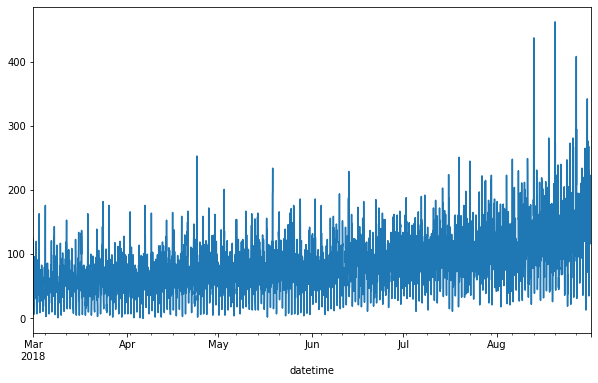

In [11]:
df['num_orders'].plot(figsize=(10,6))

Cоздадим переменную, для сравнения - исходная выборка или выборка, полученная путем разности рядов  - более стационарная. 

In [12]:
df_new = df.copy()
final_df = df.copy()
df["rolling_mean"] = df["num_orders"].rolling(20).mean()
df["rolling_std"] = df["num_orders"].rolling(20).std()

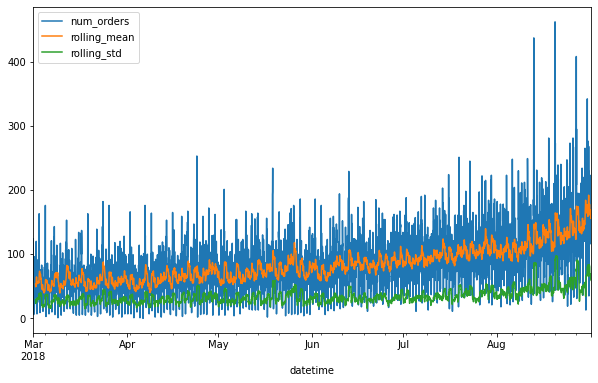

In [13]:
df.plot(figsize=(10,6))

In [14]:
#посмотрим ли сильно измениться ситуация, если получить разность ряда
df_new = df - df.shift()

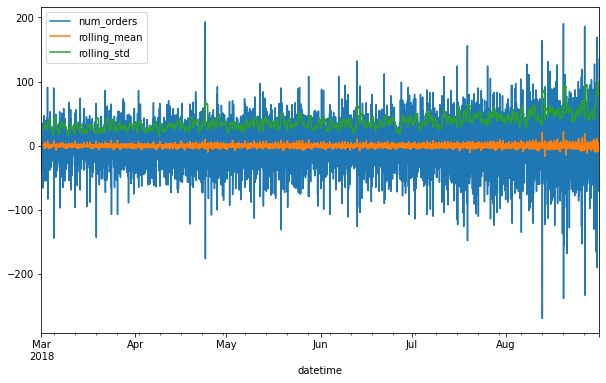

In [15]:
df_new["rolling_mean"] = df_new["num_orders"].rolling(20).mean()
df_new["rolling_std"] = df_new["num_orders"].rolling(20).std()
df_new.plot(figsize=(10,6))

In [16]:
df_new.describe()

,num_orders,rolling_mean,rolling_std
count,4415.000000,4396.000000,4396.000000
mean,0.018347,0.024488,37.989795
std,39.023437,2.801253,12.318616
min,-269.000000,-16.650000,14.839049
25%,-22.000000,-1.750000,29.647457
50%,1.000000,-0.050000,35.859650
75%,23.000000,1.650000,43.480720
max,193.000000,21.800000,100.717675


In [17]:
#Проверим стационарность ряда

st = final_df['num_orders']
st_test = adfuller(st, regression='ctt')

print('Если значение меньше P-Value, то ряд стационарный')
if st_test[1] < 0.05:
    print('Наш ряд стационарный')
else:
    print('Ряд нестационарный')

Если значение меньше P-Value, то ряд стационарный
Наш ряд стационарный


In [18]:
print('ADF Statistic: %f' % st_test[0])
print('p-value: %f' % st_test[1])
print('Critical Values:')
for key, value in st_test[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.891452
p-value: 0.000000
Critical Values:
	1%: -4.374
	5%: -3.834
	10%: -3.554


Нулевая гипотеза теста состоит в том, что временной ряд может быть представлен единичным корнем, что он не является стационарным (имеет некоторую зависящую от времени структуру). Альтернативная гипотеза (отвергающая нулевую гипотезу) состоит в том, что временной ряд является стационарным.
При выполнении примера выводится тестовое статистическое значение -10. Чем более отрицательна эта статистика, тем больше вероятность того, что мы отвергнем нулевую гипотезу (у нас есть стационарный набор данных).

In [19]:
#Удалим все признаки, которые использовались для анализа и создадим новые, 
#которые не будут получены на истинном целевом признаке

def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

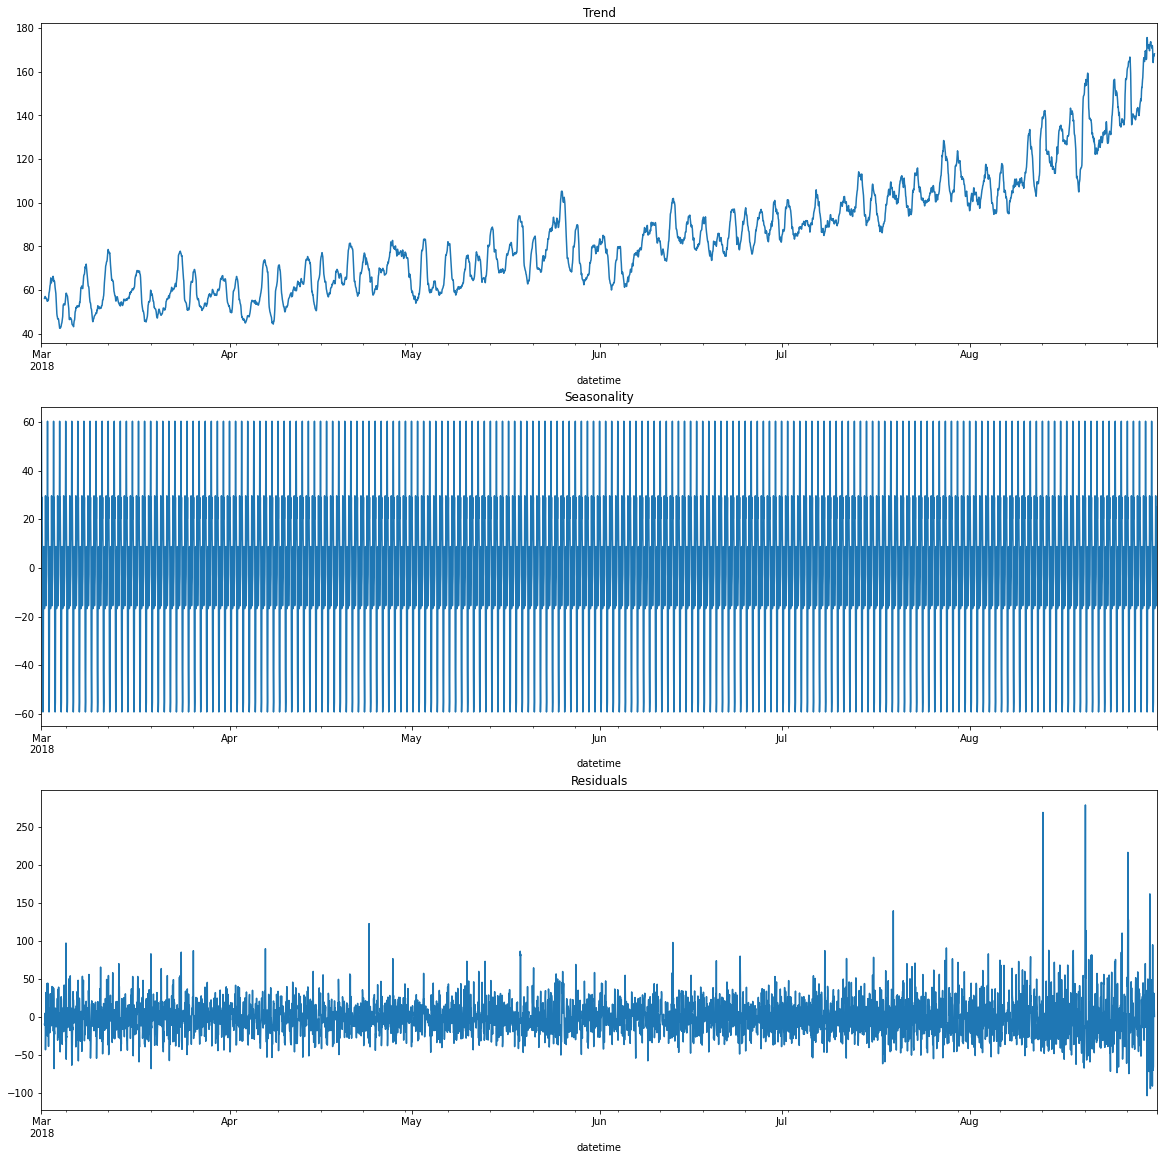

In [20]:
# Построим графики тренда и сезонности

decomposed = seasonal_decompose(final_df["num_orders"])
fig,ax = plt.subplots(3,1,figsize = (20,20))

decomposed.trend.plot(ax=ax[0],title = 'Trend')
decomposed.seasonal.plot(ax=ax[1],title = 'Seasonality')
decomposed.resid.plot(ax=ax[2],title = 'Residuals')

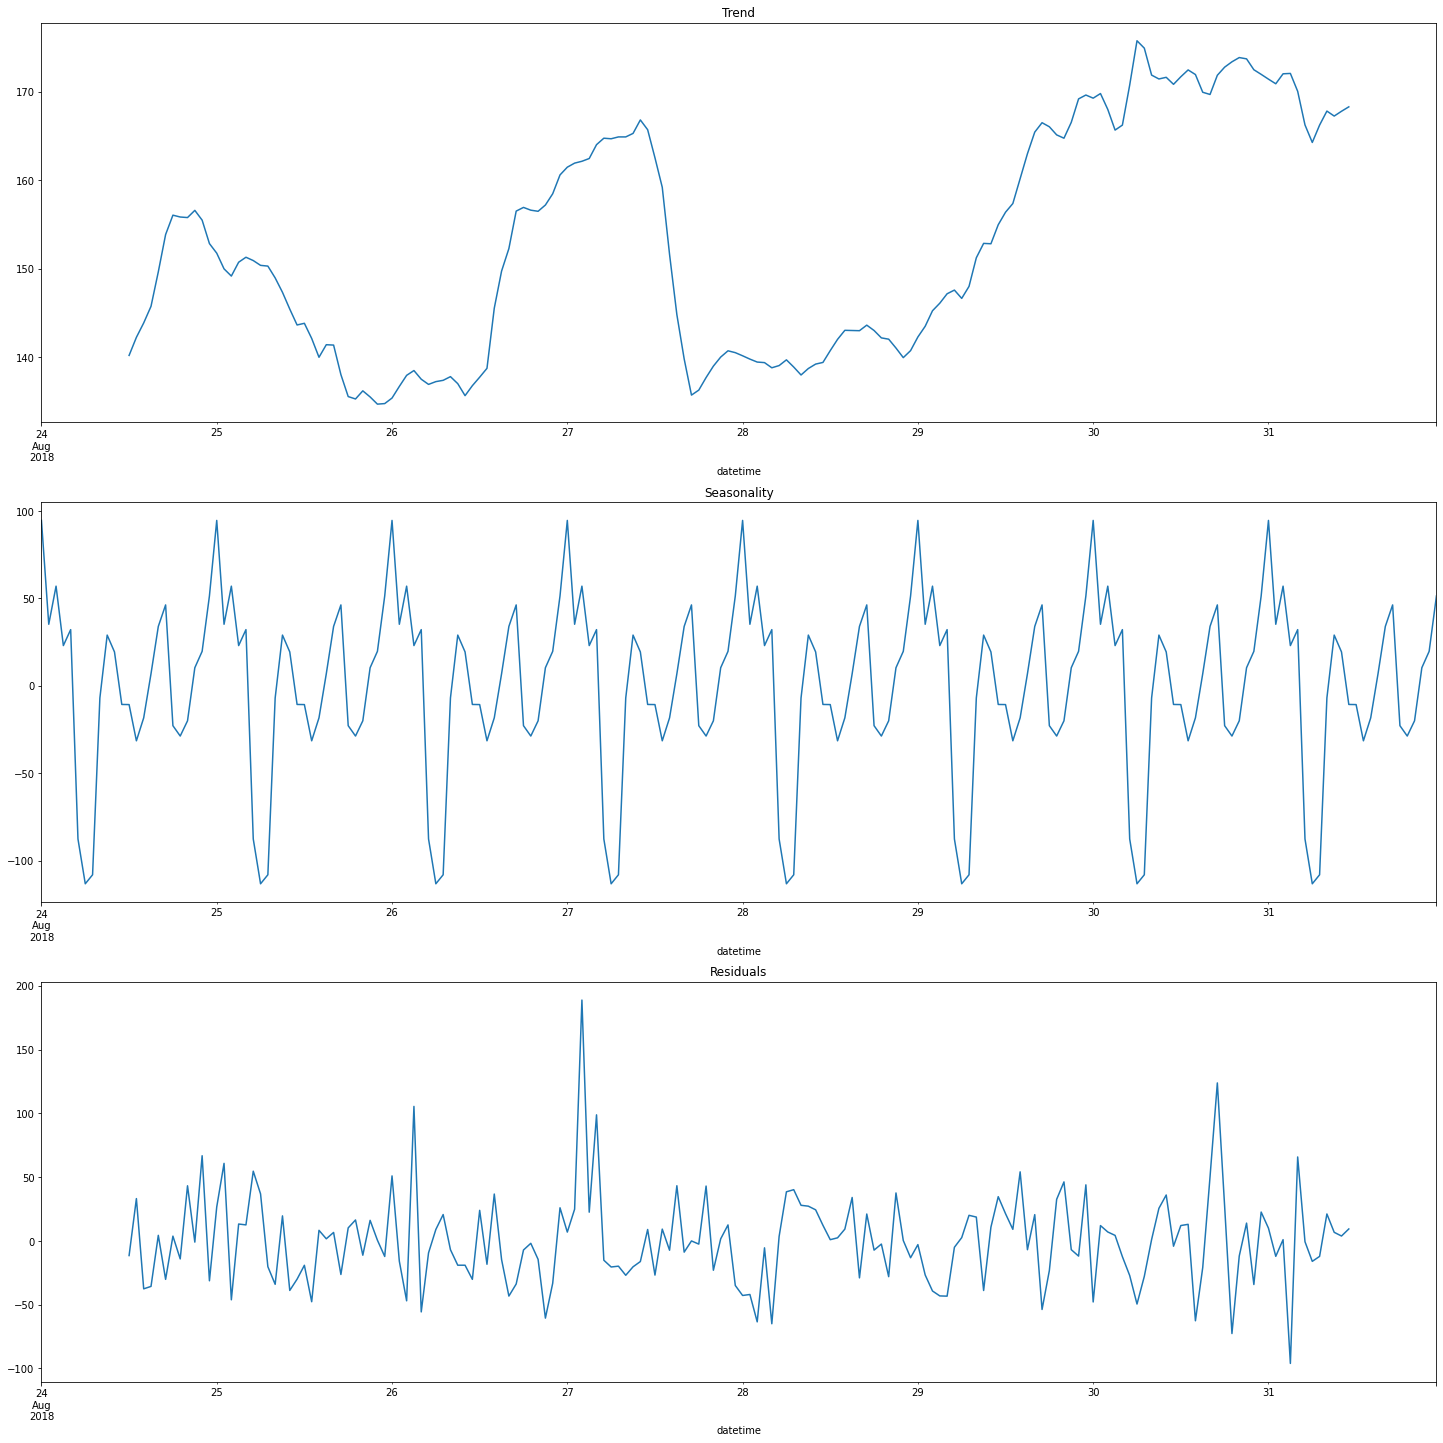

In [21]:
#Разложим последнюю неделю на три составляющие: тренд, сезонность и остаток

decomposed = seasonal_decompose(final_df["num_orders"]['2018-08-24':'2018-08-31'])
fig,ax = plt.subplots(3,1,figsize = (25,25))

decomposed.trend.plot(ax=ax[0],title = 'Trend')
decomposed.seasonal.plot(ax=ax[1],title = 'Seasonality')
decomposed.resid.plot(ax=ax[2],title = 'Residuals')

In [22]:
make_features(final_df,25,24)

### Вывод
- По тренду видно, что со временем все больше и больше людей пользуется услугой заказа такси.
- Спрос высокий в понедельник и увеличивается со среды по пятницу, выходные дни менее активны.
- При разложении по последней неделе видно, что имеются пиковые часы и больше всего такси используется в ночное время и дальше спрос максимально спадает под утро.

## Обучение

### Подготовка данных

In [23]:
train,test = train_test_split(final_df,shuffle = False, random_state = 12345, test_size = 0.1)
#valid,test = train_test_split(test,shuffle = False, random_state = 12345, test_size = 0.5)

In [24]:
train = train.dropna()

In [25]:
(features_train, features_test) = (train.drop('num_orders',axis = 1),
                  test.drop('num_orders',axis = 1))
(target_train, target_test) = (train['num_orders'],
                test['num_orders'])

### Обучение

In [26]:
# TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=3)

In [27]:
from sklearn.metrics import  make_scorer
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
def RMSE(target, prediction):
        return (mean_squared_error(target, prediction, squared=False))

RMSE_scorer = make_scorer(RMSE, greater_is_better=False)

In [28]:
%%time
abs(cross_val_score(RandomForestRegressor(), features_train, target_train, cv=tss, scoring=RMSE_scorer).mean())

CPU times: user 12.2 s, sys: 73.5 ms, total: 12.3 s
Wall time: 14.7 s


27.132456420789055

In [29]:
%%time
abs(cross_val_score(CatBoostRegressor(), features_train, target_train, cv=tss, scoring=RMSE_scorer).mean())

Learning rate set to 0.040865
0:	learn: 28.7221433	total: 61ms	remaining: 1m
1:	learn: 28.2583004	total: 71ms	remaining: 35.4s
2:	learn: 27.8032177	total: 82.4ms	remaining: 27.4s
3:	learn: 27.3349297	total: 92.6ms	remaining: 23.1s
4:	learn: 26.8951079	total: 102ms	remaining: 20.3s
5:	learn: 26.4981770	total: 121ms	remaining: 20s
6:	learn: 26.0690003	total: 140ms	remaining: 19.9s
7:	learn: 25.6848687	total: 162ms	remaining: 20.1s
8:	learn: 25.3056323	total: 179ms	remaining: 19.7s
9:	learn: 24.9783381	total: 205ms	remaining: 20.3s
10:	learn: 24.6378341	total: 219ms	remaining: 19.7s
11:	learn: 24.3418092	total: 241ms	remaining: 19.9s
12:	learn: 24.0509621	total: 248ms	remaining: 18.8s
13:	learn: 23.7519254	total: 255ms	remaining: 18s
14:	learn: 23.4754262	total: 259ms	remaining: 17s
15:	learn: 23.1982333	total: 272ms	remaining: 16.7s
16:	learn: 22.9174031	total: 312ms	remaining: 18.1s
17:	learn: 22.6730315	total: 337ms	remaining: 18.4s
18:	learn: 22.4163159	total: 346ms	remaining: 17.9s
1

25.999705432322383

In [30]:
%%time
abs(cross_val_score(LGBMRegressor(), features_train, target_train, cv=tss, scoring=RMSE_scorer).mean())

CPU times: user 1.39 s, sys: 36.1 ms, total: 1.43 s
Wall time: 752 ms


26.77264486472559

### RandomForestRegressor

In [31]:
# RandomForest
RFR = RandomForestRegressor(random_state=12345)
parametrs = {"max_depth": [1,10],"n_estimators":[100,150,10]}

RFR_grid = GridSearchCV(RFR,parametrs,cv = tss,verbose=True,n_jobs=-1, scoring=RMSE_scorer)
RFR_grid.fit(features_train,target_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=RandomForestRegressor(random_state=12345), n_jobs=-1,
             param_grid={'max_depth': [1, 10], 'n_estimators': [100, 150, 10]},
             scoring=make_scorer(RMSE, greater_is_better=False), verbose=True)

In [32]:
pprint(RFR_grid.best_params_)
pprint(abs(RFR_grid.best_score_))

{'max_depth': 10, 'n_estimators': 100}
27.03790936177717


In [33]:
%%time
RFR = RandomForestRegressor(random_state=12345)
parametrs = {"max_depth": range(10, 200, 10),  #с 10 до 200 с шагом 10
             "n_estimators":range(100, 300, 10), # c 100 до 300 с шагом 10
             "max_features" : ['auto', 'sqrt'],
             "min_samples_split": [2, 5, 10],
             "min_samples_leaf" :[1, 2, 4],
             'bootstrap': [True, False]} 

RFR_grid = RandomizedSearchCV(RFR,parametrs,cv = tss,verbose=True, n_iter = 100, n_jobs=-1, scoring=RMSE_scorer)
RFR_grid.fit(features_train,target_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
CPU times: user 10.5 s, sys: 815 ms, total: 11.3 s
Wall time: 14min 2s


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=RandomForestRegressor(random_state=12345),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': range(10, 200, 10),
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': range(100, 300, 10)},
                   scoring=make_scorer(RMSE, greater_is_better=False),
                   verbose=True)

In [34]:
pprint(RFR_grid.best_params_)
pprint(abs(RFR_grid.best_score_))

{'bootstrap': False,
 'max_depth': 120,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 240}
26.66351499755341


### CatBoostRegressor

In [35]:
%%time
# CatBoostRegressor

catboost = CatBoostRegressor(loss_function='RMSE')

parametrs = {'learning_rate':np.arange(0.01,0.1,0.01), 
             "iterations" :[1000, 2000, 100]} 

cat_grid = GridSearchCV(catboost,parametrs,cv = tss,verbose=True, n_jobs=-1, scoring=RMSE_scorer)
cat_grid.fit(features_train,target_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
0:	learn: 38.1326064	total: 8.55ms	remaining: 17.1s
1:	learn: 37.6204193	total: 15ms	remaining: 15s
2:	learn: 37.1432826	total: 21.3ms	remaining: 14.2s
3:	learn: 36.6395071	total: 27.8ms	remaining: 13.9s
4:	learn: 36.2045268	total: 34.4ms	remaining: 13.7s
5:	learn: 35.7721596	total: 40.9ms	remaining: 13.6s
6:	learn: 35.3213837	total: 47.3ms	remaining: 13.5s
7:	learn: 34.9112202	total: 53.5ms	remaining: 13.3s
8:	learn: 34.5117642	total: 59.7ms	remaining: 13.2s
9:	learn: 34.1439157	total: 66.1ms	remaining: 13.1s
10:	learn: 33.7682359	total: 72.5ms	remaining: 13.1s
11:	learn: 33.4019690	total: 78.9ms	remaining: 13.1s
12:	learn: 33.0603352	total: 85ms	remaining: 13s
13:	learn: 32.6893211	total: 91.3ms	remaining: 13s
14:	learn: 32.3832478	total: 97.5ms	remaining: 12.9s
15:	learn: 32.0905827	total: 104ms	remaining: 12.9s
16:	learn: 31.7973261	total: 111ms	remaining: 12.9s
17:	learn: 31.4750176	total: 118ms	remaining: 13s
18:	learn:

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7fae70e43790>,
             n_jobs=-1,
             param_grid={'iterations': [1000, 2000, 100],
                         'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09])},
             scoring=make_scorer(RMSE, greater_is_better=False), verbose=True)

In [36]:
pprint(cat_grid.best_params_)
pprint(abs(cat_grid.best_score_))

{'iterations': 2000, 'learning_rate': 0.03}
25.756667015614866


In [37]:
%%time
#подбираю еще парметры

catboost = CatBoostRegressor(loss_function='RMSE')
parametrs = {'depth' : [5, 10], 
                'learning_rate' : [0.03], #брала 0.03, 0.06, 0.1
                'iterations' : [300], #брала 100, 200, 300
                'verbose' : [100]
               }

cat_grid = GridSearchCV(catboost,parametrs,cv = tss,verbose=True, n_jobs=-1, scoring=RMSE_scorer)
cat_grid.fit(features_train,target_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
0:	learn: 38.1452517	total: 4.97ms	remaining: 1.49s
100:	learn: 23.7035754	total: 419ms	remaining: 826ms
200:	learn: 22.1007080	total: 823ms	remaining: 406ms
299:	learn: 20.8363752	total: 1.24s	remaining: 0us
CPU times: user 2.62 s, sys: 110 ms, total: 2.73 s
Wall time: 45.4 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7fae711242e0>,
             n_jobs=-1,
             param_grid={'depth': [5, 10], 'iterations': [300],
                         'learning_rate': [0.03], 'verbose': [100]},
             scoring=make_scorer(RMSE, greater_is_better=False), verbose=True)

In [38]:
pprint(cat_grid.best_params_)
pprint(abs(cat_grid.best_score_))

{'depth': 5, 'iterations': 300, 'learning_rate': 0.03, 'verbose': 100}
26.75536975606954


Предыдущий подбор параметров для CatBoost дал результат метрики лучше - 25.75

### LightGBMRegressor

In [39]:
%%time
# LightGBM

light = lgb.LGBMRegressor()

parametrs = {"max_depth": range(3, 12),  # от 3 до 12
             "num_leaves":range(20, 3000, 500), # от 20 до 3000
             "n_estimators" : [10000], 
             "learning_rate": [0.01, 0.3], #0.01 0.3
             "min_data_in_leaf" :[100, 1000, 100]} 

light_grid = RandomizedSearchCV(light,parametrs,cv = tss,verbose=True, n_iter = 50, n_jobs=-1, scoring=RMSE_scorer)
light_grid.fit(features_train,target_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
CPU times: user 26.1 s, sys: 4.15 s, total: 30.3 s
Wall time: 14min 54s


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=LGBMRegressor(), n_iter=50, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.3],
                                        'max_depth': range(3, 12),
                                        'min_data_in_leaf': [100, 1000, 100],
                                        'n_estimators': [10000],
                                        'num_leaves': range(20, 3000, 500)},
                   scoring=make_scorer(RMSE, greater_is_better=False),
                   verbose=True)

In [40]:
pprint(light_grid.best_params_)
pprint(abs(light_grid.best_score_))

{'learning_rate': 0.01,
 'max_depth': 4,
 'min_data_in_leaf': 100,
 'n_estimators': 10000,
 'num_leaves': 2520}
26.583386542487613


In [41]:
%%time
#подбираю еще парметры

light = lgb.LGBMRegressor()
parametrs = {'depth' : [3, 10], 
             'learning_rate':[0.03, 0.1], 
             'verbose' : [10], 
             'random_state':[12345]}

light_grid = RandomizedSearchCV(light,parametrs,cv = tss,verbose=True, n_iter = 50, n_jobs=-1, scoring=RMSE_scorer)
light_grid.fit(features_train,target_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
CPU times: user 731 ms, sys: 23.4 ms, total: 755 ms
Wall time: 3.67 s


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=LGBMRegressor(), n_iter=50, n_jobs=-1,
                   param_distributions={'depth': [3, 10],
                                        'learning_rate': [0.03, 0.1],
                                        'random_state': [12345],
                                        'verbose': [10]},
                   scoring=make_scorer(RMSE, greater_is_better=False),
                   verbose=True)

In [42]:
pprint(light_grid.best_params_)
pprint(abs(light_grid.best_score_))

{'depth': 3, 'learning_rate': 0.1, 'random_state': 12345, 'verbose': 10}
26.77264486472559


### Вывод

- Наилучшие гиперпараметры найдены
- Модели обучены и прошли валидацию

В сравнении моделей: 
- **RandomForest** 14 минут обучения
- Лучшие параметры: 'bootstrap': False, 'max_depth': 120, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 240
- RMSE : 26.66296720723844

- **CatBoost** 9 минут 
- Лучшие параметры: 'iterations': 2000, 'learning_rate': 0.03
- RMSE :25.75

-**LightGBM** 14 минут
- Лучшие параметры:'learning_rate': 0.01, 'max_depth': 4, 'min_data_in_leaf': 100, 'n_estimators': 10000, 'num_leaves': 2520
- RMSE : 26.58


Так как мы выбираем по RMSE, то меньшую ошибку выдвет CatBoost, будем тестировать ее.

## Тестирование

Вычислим время предсказаний

In [43]:
#CatBoost test-выборка

CatBoost_test_start_time = time.time()
preds_Cat_test = cat_grid.best_estimator_.predict(features_test)
CatBoost_test_total_time = time.time() - CatBoost_test_start_time
print("Время предсказаний CatBoost:", CatBoost_test_total_time)

Время предсказаний CatBoost: 0.007071018218994141


0:	learn: 38.1326064	total: 17.9ms	remaining: 35.8s
1:	learn: 37.6204193	total: 24.7ms	remaining: 24.6s
2:	learn: 37.1432826	total: 31.4ms	remaining: 20.9s
3:	learn: 36.6395071	total: 38.1ms	remaining: 19s
4:	learn: 36.2045268	total: 44.6ms	remaining: 17.8s
5:	learn: 35.7721596	total: 51.2ms	remaining: 17s
6:	learn: 35.3213837	total: 57.9ms	remaining: 16.5s
7:	learn: 34.9112202	total: 64.3ms	remaining: 16s
8:	learn: 34.5117642	total: 70.6ms	remaining: 15.6s
9:	learn: 34.1439157	total: 77.2ms	remaining: 15.4s
10:	learn: 33.7682359	total: 84ms	remaining: 15.2s
11:	learn: 33.4019690	total: 92.9ms	remaining: 15.4s
12:	learn: 33.0603352	total: 104ms	remaining: 16s
13:	learn: 32.6893211	total: 115ms	remaining: 16.3s
14:	learn: 32.3832478	total: 128ms	remaining: 17s
15:	learn: 32.0905827	total: 135ms	remaining: 16.8s
16:	learn: 31.7973261	total: 142ms	remaining: 16.5s
17:	learn: 31.4750176	total: 148ms	remaining: 16.3s
18:	learn: 31.1772901	total: 158ms	remaining: 16.5s
19:	learn: 30.8953245	

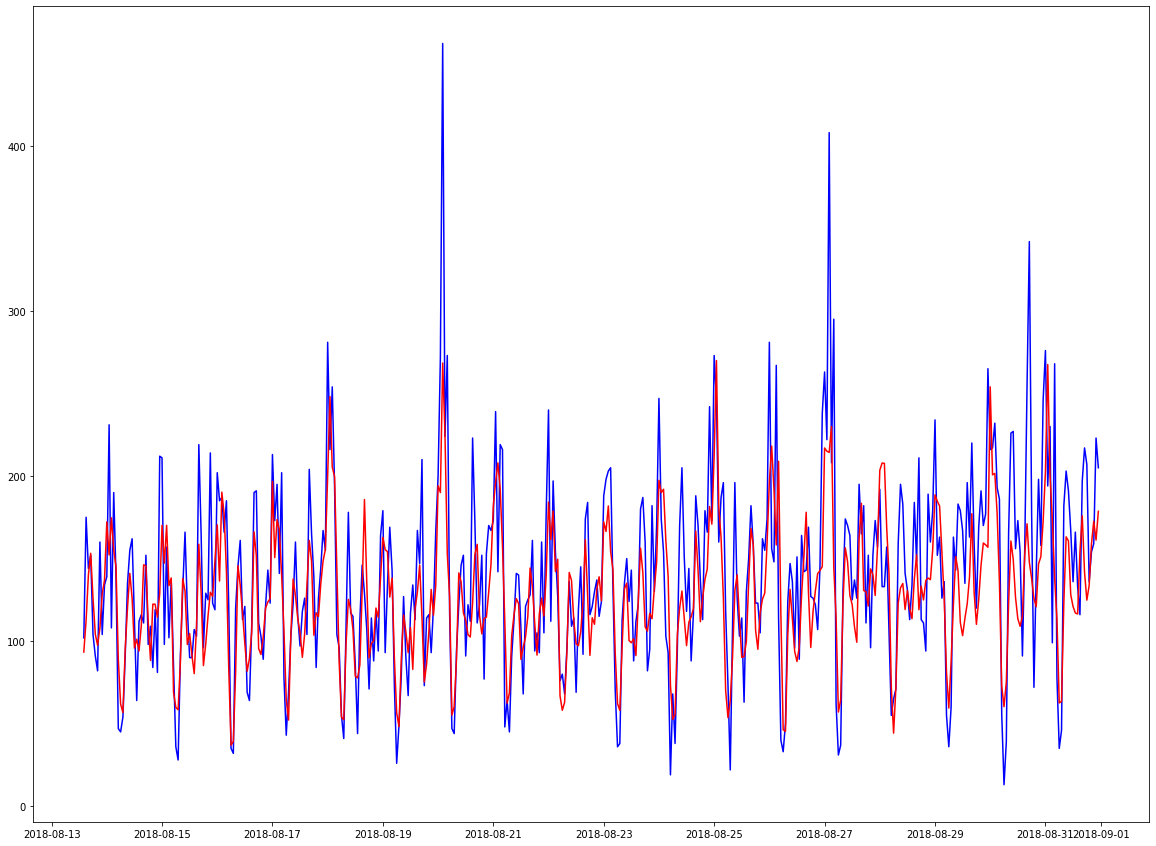

In [44]:
modelCat = CatBoostRegressor(iterations = 2000, learning_rate = 0.03)
modelCat.fit(features_train, target_train)
modelCat_predict = modelCat.predict(features_test)
rmse_cbr = mean_squared_error(target_test, modelCat_predict) ** 0.5
print(rmse_cbr)
plt.figure(figsize=(20,15))
plt.plot(target_test.index, target_test, 'b-', target_test.index, modelCat_predict,'r-')

### Вывод 

Были подготовлены данные, проведен анализ, обучены разные модели, Путем проверки обученных моделей на тестовых выборках, пришли к выводу, что модель CatBoost дает лучшие показатели RMSE, лучшее время предсказаний и лучщее время обучения.

## Общий вывод

 - Данные подготовлены к анализу, рессемлированы.
 - Построены признаки для последующего прогнозирования количества заказов - час, день, месяц, скользящее среднее и отстающие значения количества заказов. Проверен ряд на стационарность. Также построены графики тренда и сезонности. 
 - Данные подготовлены к обучению.
 - Исследованы три модели: RandomForest, CatBoost, LightGBM. Модели были обучены, выбрана модель CatBoost для тестирования, так как показала наименьшую оценку метрики. Модель может быть рекомендована для прогноза количества заказов.